In [1]:
# Connect to Elastic Cloud
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import urllib3
urllib3.disable_warnings()


es = Elasticsearch(
    ['https://86dd17d952698a0f90485f28a0087669.eu-west-1.aws.found.io'],
    port=9243,
    http_auth='elastic:9X4hmUZXasOBuF49ujcGBqLS',
    verify_certs=False
)

es.count(index='events', doc_type='batch2')

/root/anaconda3/lib/python3.6/site-packages/elasticsearch/connection/http_urllib3.py:90: UserWarning: Connecting to 86dd17d952698a0f90485f28a0087669.eu-west-1.aws.found.io using SSL with verify_certs=False is insecure.
  'Connecting to %s using SSL with verify_certs=False is insecure.' % host)


{'_shards': {'failed': 0, 'successful': 5, 'total': 5}, 'count': 2000000}

In [2]:
# Grab all the filesize for plotting
from __future__ import print_function

gen = helpers.scan(es,
    query={"query": {"match_all": {}}},
    index="events",
    doc_type="batch2"
)

# Get all filesize
i = 0
filesizes = []
for event in gen:
    if i % 10000 == 0:
            print('.', end='')
    i += 1
    #print(event)
    filesizes.append(int(event['_source']['bytes']))
print("Done!")

........................................................................................................................................................................................................Done!


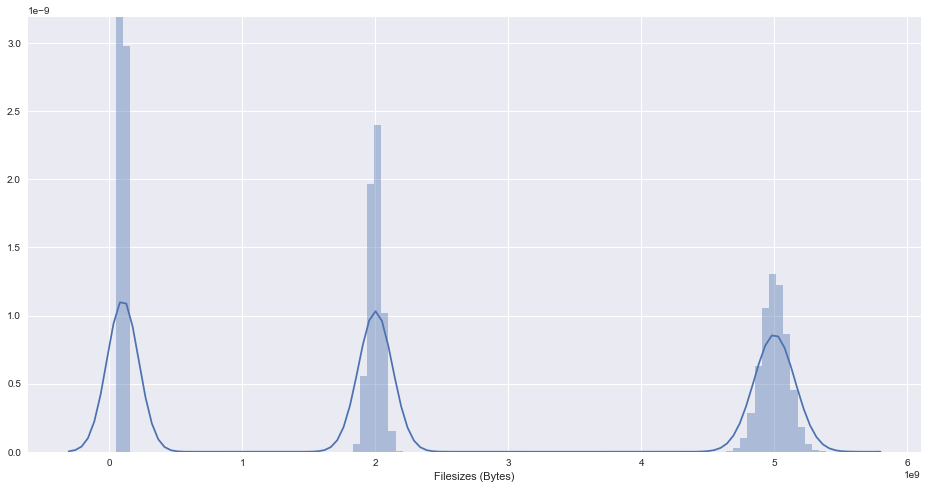

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
sns.set(rc={"figure.figsize": (16, 8)})
ax = sns.distplot(filesizes, bins=100, kde=True, rug=False)
ax.set_xlabel("Filesizes (Bytes)")

In [4]:
# Get data centre info from all the transfer records

gen = helpers.scan(es,
    query={"query": {"match_all": {}}},
    index="events",
    doc_type="batch2"
)

dc = np.zeros((5,5), dtype=np.int)
dc_filesize = np.zeros((5,5), dtype=np.int)

data_centres = ["data centre a",
                "data centre b",
                "data centre c",
                "data centre d",
                "data centre e"]
data_centres.index("data centre d")

# Get all filesize
i = 0
event_types = [0,0,0]
event_types_names = []
for event in gen:
    if i % 10000 == 0:
            print('.', end='')
    i += 1
    #print(event)
    src = data_centres.index(event['_source']['src_site'])
    dst = data_centres.index(event['_source']['dst_site'])
    
    if event['_source']['event_type'] == 'transfer-success':
        dc[src][dst] += 1
        dc_filesize[src][dst] += event['_source']['bytes']

print("Done!")

........................................................................................................................................................................................................Done!


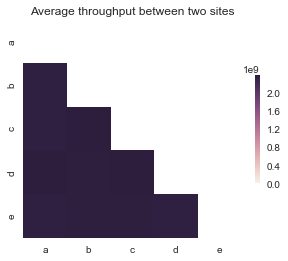

In [7]:
'''
Plot the average throughput between every two data centres

However, due to the pure random generator, there isn't noticeable difference on the graph
'''

import pandas as pd
from string import ascii_letters as letters
sns.set(style="white")

dc[dc==0] += 1
avg_throughput = dc_filesize / dc.astype(float)
hmap = pd.DataFrame(data=avg_throughput.astype(int),
                    columns=list(letters[:5]))

# Generate a mask for the upper triangle
mask = np.zeros_like(avg_throughput, dtype=np.bool)
mask[np.triu_indices_from(avg_throughput)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 4))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(hmap, mask=mask,
            square=True, xticklabels=True, yticklabels=list(letters[:5]),
            cbar_kws={"shrink": .5}, ax=ax)
plt.title("Average throughput between two sites")